# Example Experiment Notebook with Tabular Reinforcement Learning Agents

*Author*: Joery A. de Vries

This notebook is intended to illustrate the designed API built on top of MazeLab for running gridworld/ tabular environment reinforcement learning experiments.

**Structure of this notebook**:
 - Dependencies
 - Basic API
     - EnvironmentRegister
     - AgentShelve
 - Example experiment Q-learning.
 - Benchmarking API
      - Flat Q-learning Vs. DynaQ.

In [1]:
# Reload dependencies upon changes
%load_ext autoreload
%autoreload 2

## Dependencies

In [2]:
from functools import partial
import typing
import sys

import numpy as np
import gym
import tqdm
import matplotlib.pyplot as plt

from mazelab_experimenter import EnvRegister
from mazelab_experimenter import AgentShelve
from mazelab_experimenter import benchmark, GenericOuterHook

## The Environment Register

The [MazeLab API](https://github.com/zuoxingdong/mazelab) can be extended and accessed to easily interfaced with OpenAI Gym through the `EnvRegister`. This is merely a wrapper for instantiating varying maze-environments. This functionality can be useful for setting up experiments through one unified API. The code snippets below illustrate the functionality and the available options.

In [3]:
# Print out the API of the EnvRegister static class.
help(EnvRegister)

Help on class EnvRegister in module mazelab_experimenter.Environment:

class EnvRegister(builtins.object)
 |  Static utility class to serve as a wrapper to register custom MazeLab environments in the OpenAI Gym interface.
 |  
 |  Static methods defined here:
 |  
 |  get_initialization_args() -> str
 |      Get the initialization arguments needed for instantiating an *agent* in a MazeLab environment.
 |      :returns: str Example/ dummy dictionary string for formatting the initialization argument for initializing an agent.
 |  
 |  get_keyword_args(maze_type: str) -> inspect.Signature
 |      Retrieve the environment/ generator specific function arguments for a particular MazeLab environment.
 |      
 |      :param maze_type: str One of the module names within EnvRegister._MODULES
 |      :see: EnvRegister.get_types to retrieve a list of all generators
 |      :see: mazelab.generators for the backend code of the generators
 |  
 |  get_types() -> List[str]
 |      Get all available i

In [4]:
print(f"Currently there are {len(EnvRegister.get_types())} registered Maze environments in MazeLab framework BackEnd.")
for i, e in enumerate(EnvRegister.get_types()):
    print(f"{i:2d}: {e}")

Currently there are 12 registered Maze environments in MazeLab framework BackEnd.
 0: double_t_maze
 1: dyna_example
 2: four_rooms
 3: four_rooms_HierQ
 4: gridworld
 5: morris_water_maze
 6: n_rooms_square
 7: prebuilts
 8: random_maze
 9: random_shape_maze
10: t_maze
11: u_maze


**Note**: Environments need to be registered in OpenAI Gym before you can instantiate it with the `gym.make` call. 

The code below illustrates usage of the EnvRegister API in an experiment involving a random controller.

In [5]:
def example_usage_ER() -> None:
    # Register and initialize a dummy random maze of dimensions 10x10 with a time limit of 5 steps.
    h, w, t = 10, 10, 5
    name = EnvRegister.register(
        maze_type='random_maze', 
        name=f'example_usage-v0', 
        env_args=dict(
            shortest_path_rewards=True
        ),
        generator_args=dict(
            width=w, height=h
        ),
        initialization_args=dict(
            start_pos=[[1, 1]], goal_pos=[[2, 2]]
        ),
        time_limit=t
    )
    env = gym.make(name)
    motions = env.unwrapped.motions  # Metadata for plotting later on
    
    # Let a random controller play in the maze and collect state-images.
    state, g, done, _ = env.reset(), 0, False, None
    imgs, actions = [env.unwrapped.get_image()], []
    
    while not done:
        # Update to the next state.
        a = np.random.randint(env.action_space.n)
        state, r, done, _ = env.step(a)
        
        # Update storage.
        g += r
        imgs.append(env.unwrapped.get_image())
        actions.append(a)

    # Close and unregister the example environment to avoid clashes later on.
    env.close()
    EnvRegister.unregister(name)
        
    # Show what the agent did during the short control episode.
    f, axarr = plt.subplots(1, len(imgs), figsize=(len(imgs) * 4, 4))
    
    def add_frame(idx: int, img: np.ndarray, title: str = "") -> None:
        # Helper plotting function.
        axarr[idx].imshow(img, interpolation=None)
        axarr[idx].set_title(title)
    
    for i in range(len(imgs)):  # Neatly plot all frames and with their preceding actions.
        add_frame(i, imgs[i], f'action = {motions[actions[i-1]]}' if i > 0 else "")
    
    plt.show()
    


**Run example**: You can run the snippet example below to execute the function defined above, try running it multiple times to see that the random agent occasionally reaches the goal and that the environment terminates accordingly!


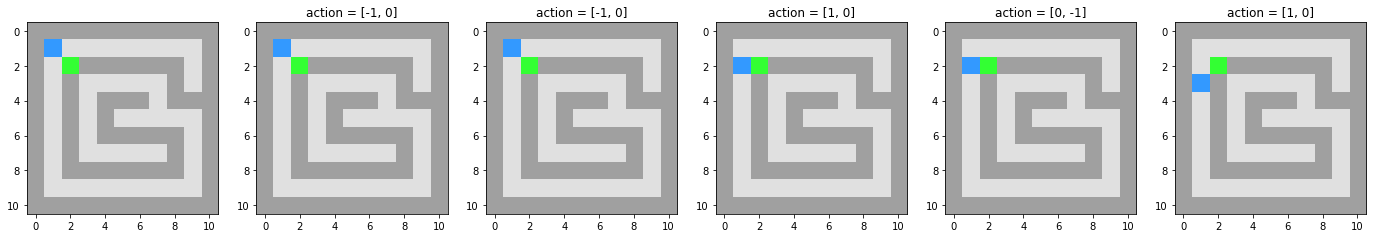

In [6]:
example_usage_ER()

**Note**: to add MazeLab environments, write a generic generator function in the `mazelab/generators/` module and import it in the `mazelab/generators/__init__.py` file! See the code for examples.

## The Agent Shelve

After defining tabular environments in your imported OpenAI Gym module, you could use any of the implemented tabular reinforcement learning algorithms to solve the environments. This shelve of agents also includes the original dijkstra solver from MazeLab to compare learned solutions to the optimal paths. The code samples below illustrate this API's functionality, which is entirely supplementary to the EnvRegister.

In [7]:
# Print out the API of the AgentShelve static class.
help(AgentShelve)

Help on class AgentShelve in module mazelab_experimenter.AgentShelve:

class AgentShelve(builtins.object)
 |  Static utility class for retrieving and defining agents to interface with various algorithms that can act in the OpenAI Gym interface.
 |  
 |  Static methods defined here:
 |  
 |  get_keyword_args(agent: str) -> inspect.Signature
 |      Retrieve the class constructor arguments for a specified agent.
 |      
 |      :param agent: str One of the agent names within AgentShelve._IMPLEMENTED
 |      :see: mazelab.generators
 |  
 |  get_types()
 |      Get all available implemented agents defined in _IMPLEMENTED. :see: mazelab_experimenter.agents for the backend code.
 |  
 |  print_interface()
 |      Access the documentation of the basic Agent interface.
 |  
 |  retrieve(agent: str, keyword_arguments: dict) -> mazelab_experimenter.agents.interface.Agent
 |      Instantiate and return an implemented agent algorithm.
 |      
 |      All agents are designed to interface with Op

In [8]:
print(f"Currently there are {len(AgentShelve.get_types())} available agents in the MazeLab_experimenter BackEnd.")
for i, e in enumerate(AgentShelve.get_types()):
    print(f"{i:2d}: {e}")

Currently there are 12 available agents in the MazeLab_experimenter BackEnd.
 0: TabularQLearner
 1: TabularQLearnerN
 2: TabularQLambda
 3: TabularQET
 4: TabularDynaQ
 5: MonteCarloQLearner
 6: RandomAgent
 7: HierQ
 8: HierQV2
 9: HierQTD
10: HierQTS
11: HierQET


Agents defined in the AgentShelve are allowed to follow their own unique interface with the exception of three primitive methods, these are inherited from the base Agent class. This base class requries all derived classes to implement a `sample`, `update`, and `reset` method. The snippet below prints out the interface documentation.

In [9]:
AgentShelve.print_interface()

Help on class Agent in module mazelab_experimenter.agents.interface:

class Agent(abc.ABC)
 |  Agent(observation_shape: Tuple, n_actions: int) -> None
 |  
 |  Basic Agent interface, inherit this class to implement algorithms compatible with the experimentation API.
 |  
 |  Method resolution order:
 |      Agent
 |      abc.ABC
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, observation_shape: Tuple, n_actions: int) -> None
 |      Initialize root with domain dimensions. 
 |      :param observation_shape: tuple Indicates the dimensionality of the environment's observations.
 |      :param n_actions: int The environment's action space dimension.
 |  
 |  reset(self) -> None
 |      Refreshes all stateful variables/ reinitializes the agent.
 |  
 |  sample(self, state: numpy.ndarray, **kwargs) -> Union[int, float, numpy.ndarray]
 |      Sample an action given an environment context (state) and return an action.
 |  
 |  train(self, _env: gym.core.Env, **kw

## Example experiment with simple Tabular Q-Learning
Agents that are retrieved from the AgentShelve can conveniently be interface with the OpenAI Gym module. If an agent is a Reinforcement Learning agent/ can adapt its parameters based on sequential decision making, the agent can be trained in two methods. The agent can either have its own training loop that is implemented in the `Agent.train` method, or you can write your own training loop and canonically update the Agent's parameters through the `Agent.update` call. The keyword arguments of these function varies over algorithms, which may make the `Agent.train` functionality more convenient.

In the following code snippets we define our own training and evaluation loop to illustrate the functionality outside the `Agent.train` function. We do this using a simple Tabular Q-learning agent. This agent is initialized with various parameters and most importantly a state-action value table (Q-table). During training, for choosing an action among a discrete set $\{a_1, \cdots, a_N\}$ given some current environment state $s_t$, the agent either consults its Q-table through maximization or acts uniformly random ($\epsilon$-greedy):

$$a_t \sim b(a \: | \: s_t) = \begin{cases}\max_a Q(s_t, a) & \text{Greedy with probability }1 - \epsilon \\ \text{Unif}(\{a_1, \cdots, a_N\}) & \text{Uniformly random with probability }\epsilon \end{cases}$$

The Q-table is updated based on the state-transition tuple $\langle s_t, a_t, r_{t+1}, s_{t+1} \rangle$, for which the user can either specify a SARSA update (bootstrap according to $b(a \: | \: s_{t+1})$) or a Q-learning update (bootstrap according to the greedy policy $\pi_*(a \: | \: s_{t+1})$. Denote a policy $\pi(s)\rightarrow a$ as a function that maps states to actions, then the update rule for the tabular Q-learning agent is defined as:

$$Q(s_t, a_t) = Q(s_t, a_t) + \alpha [r_t + \gamma Q(s_{t+1}, \pi(s_{t+1})) - Q(s_t, a_t)]$$

Here, $\alpha$ is the learning rate and $\gamma$ is a discount factor. For a complete overview of this method, see the book by \[[R. Sutton and A. Barto, 2018](http://incompleteideas.net/book/the-book-2nd.html)\].

**Example code**: we register a new randomly generated random-shape-maze and illustrate the problem visually. You can run the snippet multiple times to generate varying environments.

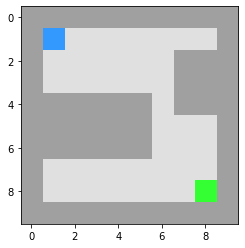

In [10]:
# Create and register a MazeLab random-shape-maze.
w, h, t = 10, 10, 500
name = EnvRegister.register(
    maze_type='random_shape_maze', 
    name=f'q_learning_example-v0', 
    env_args=dict(
        shortest_path_rewards=True
    ),
    generator_args=dict(
        width=w, height=h, max_shapes=4, max_size=4, allow_overlap=False, shape=None
    ),
    initialization_args=dict(
        start_pos=[[1, 1]], goal_pos=[[8, 8]]
    ),
    time_limit=t,
    override=True
)

# Instantiate the registered MazeLab environment as a Gym environment.
env = gym.make(name)

# Illustrate the randomly generated maze. 
_ = env.reset()
img = env.unwrapped.get_image()
env.close()

plt.imshow(img)
plt.show()

Then we initialize the agent with its default parameters, the signature below illustrates that the algorithm defaults to the Q-learning update rule (you could try tune the parameters to evaluate the impact).

In [11]:
# Print out the constructor arguments for our Q-learning agent.
AgentShelve.get_keyword_args('TabularQLearner')

<Signature (observation_shape: 'typing.Tuple[int, int]', n_actions: 'int', lr: 'float' = 0.5, epsilon: 'float' = 0.1, discount: 'float' = 0.95, sarsa: 'bool' = False, q_init: 'float' = 0.0) -> 'None'>

In [12]:
# Initialize our agent with the environment dimensions.
agent = AgentShelve.retrieve(
    agent='TabularQLearner', 
    keyword_arguments=dict(
        observation_shape = env.observation_space.shape,
        n_actions = env.action_space.n,
    )
)

The code block below defines two helper functions for training and evaluating our Q-learning agent.

In [13]:
def train(_env, _agent, num_episodes: int) -> None:
    # Helper function for defining an agent training loop.
    
    for i in range(num_episodes):
        # Reinitialize environment after each episode.
        state, goal_achieved, done = env.reset(), False, False
        
        while not done:
            # Update to the next state.
            a = _agent.sample(state)
            next_state, r, done, _ = _env.step(a)

            # Annotate an episode as done if the agent is actually in a goal-state (not if the time expires).
            if done:
                goal_achieved = _env.unwrapped._is_goal(_env.unwrapped.maze.objects.agent.positions[0])
            
            # Q-learning update
            _agent.update(state, a, r, next_state, goal_achieved)

            # Update state of control.
            state = next_state
            
        # Cleanup environment variables
        env.close()
            
            
def evaluate(_env, _agent, num_evals: int) -> typing.Tuple[typing.List, typing.List, typing.List]:
    # Helper function for defining an agent evaluation loop.
    
    rewards, lengths, success = [], [], []
    for i in range(num_evals):
        # Reinitialize environment and monitorring variables after each episode.
        state, g, step, goal_achieved, done = env.reset(), 0, 0, False, False

        while not done:
            # Update to the next state.
            a = agent.sample(state, behaviour_policy=False)
            next_state, r, done, _ = env.step(a)
            
            # Annotate an episode as done if the agent is actually in a goal-state (not if the time expires).
            if done:
                goal_achieved = _env.unwrapped._is_goal(_env.unwrapped.maze.objects.agent.positions[0])
            
            # Update state of control.
            g += r
            step += 1
            state = next_state

        # Store agent episode data.
        rewards.append(g)
        lengths.append(step)
        success.append(goal_achieved)
        
        # Cleanup environment variables
        env.close()
        
    # Return agent evaluation data.
    return rewards, lengths, success

In [14]:
# Define training parameters
num_train = 50                # Number of outer loop repetitions (train-evaluate loop)
num_eps = 5                   # Number of episodes to train an agent on within one outer loop repetition.
num_test = 1                  # Number of episodes to evaluate an agent on within one outer loop repetition (can be set to 1 if greedy)

# Test the freshly initialized agent (without parameter updates; may take a couple of seconds) and store results.
data = [evaluate(_env=env, _agent=agent, num_evals=num_test)]

# The progress of the agent can seem slow in the beginning for small `num_eps`
# This will rapidly accelerate once a decent q-table is found.
for _ in tqdm.trange(num_train, file=sys.stdout):
    
    # Train the agent for a number of times
    train(_env=env, _agent=agent, num_episodes=num_eps)
    
    # Test the agent after it has updated its parameters.
    data.append(evaluate(_env=env, _agent=agent, num_evals=num_test))


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:04<00:00, 12.14it/s]


In [15]:
# OPTIONAL: For retraining the agent, reset its q-table here. Skip this snippet for the visualization. 
reset = False
if reset:
    agent.reset()

### Visualization

In the following two code blocks we visualize the (trained) Q-learning agent based on its training progress and its (learned) Q-table.

**Progression Line Plots**

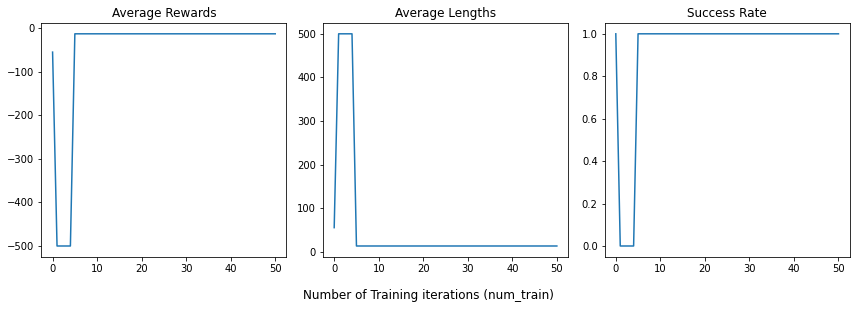

In [16]:
# Create a simple line plots of the agent's rewards, episode-lengths, and success-rates.
f, axarr = plt.subplots(1, 3, figsize=(12, 4))

values = list(zip(*data))
labels = ['Average Rewards', 'Average Lengths', 'Success Rate']

for i, (vs, lab) in enumerate(zip(values, labels)):
    axarr[i].plot(list(map(np.mean, vs)))
    axarr[i].set_title(lab)
    
# Annotate x-labels
f.text(0.5, -0.05, 'Number of Training iterations (num_train)', ha='center', fontsize=12)
plt.tight_layout()
plt.show()

**Q-Table Policy Visualization**

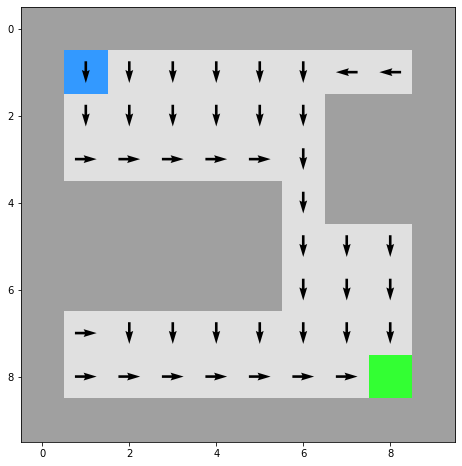

In [17]:
plt.figure(figsize=(8, 8))

# Get the trained agent's policy over the entire table for visualizing its greedy policy.
actions = np.argmax(agent._q_table, axis=-1)

# Get undefined coordinates for removing clutter in the image.
mask = env.unwrapped.maze.objects.obstacle.positions.tolist() + env.unwrapped.maze.objects.goal.positions.tolist()
mask = set(map(tuple, mask))

motions = [(env.unwrapped.motions[a] if np.unravel_index(i, shape=actions.shape) not in mask else [0, 0]) for i, a in enumerate(actions.ravel())]

# Define a grid and extract for each grid-point a correct Quiver/ Arrow direction for visualizing the action-selection policy.
X, Y = np.meshgrid(np.arange(img.shape[0]), np.arange(img.shape[1]))
V, U = list(zip(*motions))
U = np.asarray(U)
V = np.negative(V)  # Motion is inverted vertically.

# Show the maze image with overlayed quivers. The minlength=0.0 argument removes all quivers on invalid states.
plt.imshow(img)
plt.quiver(X, Y, U, V, scale=20, minlength=0.0, pivot='middle', linewidth=0.1) 


plt.show()

## Benchmarking API

To conveniently set up benchmarking experiments between varying agents, you can set up the entire train loop within the agents (see the agents.Agent interface) and evaluate the updated agents episodically. This process can be repeated for a number of times, either asynchronously or on one thread. The functionality is contained within the `benchmark` function, and its functionality mostly follows the `train` and `evaluate` function that was shown earlier for the simple Q-learning agent.


In [18]:
help(benchmark)

Help on function benchmark in module mazelab_experimenter.Experimenter:

benchmark(env_id: str, _agent_gen: Callable, agent_test_kwargs: Dict, agent_train_kwargs: Dict, num_repetitions: int, num_iterations: int, num_episodes: int, num_trials: int, evaluation_hooks: List[mazelab_experimenter.Experimenter.Hook], verbose: bool = True, asynchronous: bool = False, **kwargs) -> List
    Full functionality for benchmarking a single reinforcement learning.
    
    This function can either be run on a single thread (default) or run each repetition asynchronously batch-wise (NOT YET IMPLEMENTED).
    
    The function initializes a fresh gym environment given a string identifier along with a fresh agent, it then repeats a train-test loop
    and logs only evaluation statistics through the evaluation_hooks. The function returns the per test-episode aggregated Hook data. 
    
    The Hook class is a monitorring class similarly to keras.Callbacks that is used here strictly for outer-episode stati

At the core for monitorring your agents' progress is the `Hook` class, this works similarly to the Callback class in Keras. The `benchmark` function takes as arguments the generator parameters for creating a Gym environment and a fresh agent, along with keyword arguments for the train and test loop for the agent, the benchmark size specification (repetitions, iterations, episodes, trials), and two lists of `Hook` objects. The outer `Hook`s are monitors that log the statistics on an episodic basis, while the inner `Hook`s do this during the generation of an action trace (during the episode). The implementation is highly generic and allows for a large degree of customization, we illustrate one example of an outer `Hook` below.

In [19]:
help(GenericOuterHook)

Help on class GenericOuterHook in module mazelab_experimenter.Experimenter:

class GenericOuterHook(Hook)
 |  GenericOuterHook(f_aggr: Callable = <function mean at 0x000001EA7FEAD048>) -> None
 |  
 |  Simple episodic monitor for control agents that logs and aggregates the success-rate, cumulative reward, and episode length.
 |  
 |  Method resolution order:
 |      GenericOuterHook
 |      Hook
 |      abc.ABC
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, f_aggr: Callable = <function mean at 0x000001EA7FEAD048>) -> None
 |      Initialize the monitorring hook with an aggregation function. Defaults to a sample average.
 |      
 |      :param f_aggr: typing.Callable Aggregation function for summarizing collected statistics.
 |  
 |  aggregate(self, **kwargs) -> Tuple[float, float, float]
 |      Aggregate the logged statistics over the episodes with self._f_aggr in order of self.labels.
 |  
 |  clear(self) -> None
 |      Clear internal state variables

**Example Benchmark of Planning steps in DynaQ**: To illustrate the functionality of the benchmarking API, the code below defines a benchmarking experiments that tests out three values for the number of planning steps in DynaQ: $n \in \{0, 5, 50\}$. Additionally it shows a DynaQ agent with Prioritized Sweeping and $n=5$ planning steps, however this agent is trained here for testing purposes. The environment used is the maze that was shown as an example in Chapter 8.2 of \[[R. Sutton and A. Barto, 2018](http://incompleteideas.net/book/the-book-2nd.html)\], which is also defined/ shown below:

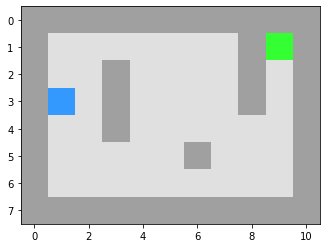

In [20]:
# Create and register a MazeLab random-shape-maze.
name = EnvRegister.register(
    maze_type='dyna_example', 
    name=f'sparse_dyna_example-v0', 
    env_args=dict(
        shortest_path_rewards=True
    ),
    generator_args=dict(),
    initialization_args=dict(
        start_pos=[[3, 1]], goal_pos=[[1, 9]]
    ),
    time_limit=2_000,
    override=True
)

# Instantiate the registered MazeLab environment as a Gym environment.
env = gym.make(name)

# Illustrate the randomly generated maze. 
_ = env.reset()
img = env.unwrapped.get_image()
env.close()

plt.imshow(img)
plt.show()

To compare agents, we define three different generators for initializing the same agent with different hyperparameters.

In [21]:
# Initialize our agent with the environment dimensions.
agent_generators = [
    lambda: AgentShelve.retrieve(
            agent='TabularQLearner', 
            keyword_arguments=dict(
            observation_shape = env.observation_space.shape,
            n_actions = env.action_space.n,
            q_init=0, discount=0.95, epsilon=0.1, lr=0.1
            )
    ),
    lambda: AgentShelve.retrieve(  # n = 0
        agent='TabularDynaQ', 
        keyword_arguments=dict(
            observation_shape = env.observation_space.shape,
            n_actions = env.action_space.n,
            q_init=0, n_iter=0, discount=0.95, epsilon=0.1, lr=0.1
        )
    ),
    lambda: AgentShelve.retrieve(  # n = 5
        agent='TabularDynaQ', 
        keyword_arguments=dict(
            observation_shape = env.observation_space.shape,
            n_actions = env.action_space.n,
            q_init=0, n_iter=5, discount=0.95, epsilon=0.1, lr=0.1
        )
    ),
    lambda: AgentShelve.retrieve(  # n = 5 Prioritized Sweeping
        agent='TabularDynaQ', 
        keyword_arguments=dict(
            observation_shape = env.observation_space.shape,
            n_actions = env.action_space.n,
            q_init=0, n_iter=5, discount=0.95, epsilon=0.1, lr=0.1, priority=0.5
        )
    ),
    lambda: AgentShelve.retrieve(  # n = 50
        agent='TabularDynaQ', 
        keyword_arguments=dict(
            observation_shape = env.observation_space.shape,
            n_actions = env.action_space.n,
            q_init=0, n_iter=50, discount=0.95, epsilon=0.1, lr=0.1
        )
    )
]

And finally we run the actual benchmark in the block below.

In [22]:
# Benchmark configuration
r = 5
it = 50
eps = 3
trials = 1

# Benchmark data for each agent.
benchmark_data = list()

for agent_gen in agent_generators:
    
    # Run the benchmark
    benchmark_data.append(
        benchmark(
            env_id=name, 
            _agent_gen=agent_gen, 
            agent_test_kwargs=dict(behaviour_policy=False),
            agent_train_kwargs=dict(),
            num_repetitions=r,
            num_iterations=it,
            num_episodes=eps,
            num_trials=trials,
            evaluation_hooks=[GenericOuterHook()],
            verbose=True,
            asynchronous=False
        )
    )

-- Benchmarking Repetition 1 / 5 --- ETA:  --- Rate: 0 sec/ it
Train-Test loop: 100%|█████████████████████████████████████████████████████████████████| 50/50 [00:08<00:00,  6.04it/s]
-- Benchmarking Repetition 2 / 5 --- ETA: 0:00:33 --- Rate: 8 sec/ it
Train-Test loop: 100%|█████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.39it/s]
-- Benchmarking Repetition 3 / 5 --- ETA: 0:00:26 --- Rate: 8 sec/ it
Train-Test loop: 100%|█████████████████████████████████████████████████████████████████| 50/50 [00:08<00:00,  5.76it/s]
-- Benchmarking Repetition 4 / 5 --- ETA: 0:00:17 --- Rate: 8 sec/ it
Train-Test loop: 100%|█████████████████████████████████████████████████████████████████| 50/50 [00:07<00:00,  6.52it/s]
-- Benchmarking Repetition 5 / 5 --- ETA: 0:00:08 --- Rate: 8 sec/ it
Train-Test loop: 100%|█████████████████████████████████████████████████████████████████| 50/50 [00:07<00:00,  6.90it/s]
-- Benchmarking Repetition 1 / 5 --- ETA:  --- Rate: 0 se

**Visualize Benchmark Results**:

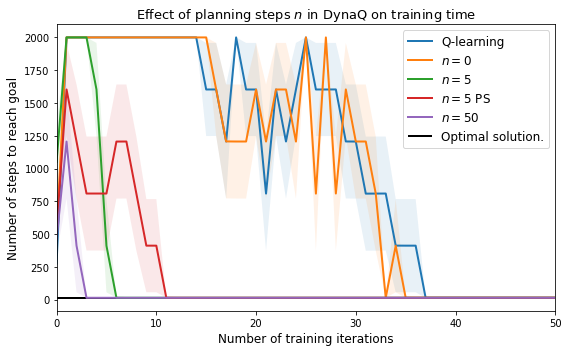

In [23]:
plt.figure(figsize=(8, 5))
for a, l in zip(benchmark_data, [r'Q-learning', r'$n=0$', r'$n=5$', r'$n=5$ PS', r'$n=50$']):
    a = np.asarray(a)
    
    # Plot the average lengths and approximation error.
    mean_length = a[...,2][...,0].mean(axis=0)
    std_length = a[...,2][...,0].std(axis=0) / np.sqrt(r)

    plt.plot(mean_length, label=l, linewidth=2)
    plt.fill_between(np.arange(len(mean_length)), mean_length + std_length, mean_length - std_length, alpha=0.1)

# Optimal solution on this example is 14 steps.
plt.hlines(14, 0, 50, label='Optimal solution.', color='black', linewidth=2)
    
plt.xlim([0, 50])

plt.title("Effect of planning steps $n$ in DynaQ on training time", fontsize=13)
plt.ylabel("Number of steps to reach goal", fontsize=12)
plt.xlabel("Number of training iterations", fontsize=12)

plt.legend(fontsize=12)

plt.tight_layout()
plt.show()

What we see in this benchmark's results is that the DynaQ agent with $n=50$ converges almost instantly to the optimal policy (14 steps). The $n=5$ agent also converges swiftly, and the non-planning agents ($Q$-learning $\equiv n=0$) converge much slower. The basic Q-learning agent eventually does seem to learn the optimal policy first (14 steps). For the $n=5$ agents the progress seems on par with either Prioritized Sweeping or no Priotized Sweeping, but this may scale differently with different environment dimensionalities as argued in Chapter 8.4 of Sutton's book.

## Backup Visualization

The `Visualization.py` file defines two helper functions for making quick figures of backup patterns or Q-table policies given an agent on some environment. The snippets below illustrate the functionality on a simple gridworld for $Q$-Learning and the backup gradients. The code is mainly intended to serve as placeholders for more advanced visualizations. 
Here we visualize backup patterns portrayed by varying Q-learning agents.

In [24]:
from mazelab_experimenter.Visualization import plotQPolicy, plotQTable

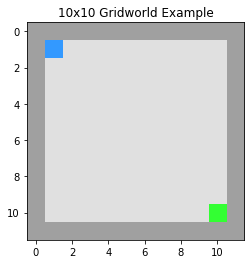

In [25]:
name_gridworld = EnvRegister.register(
    maze_type='gridworld', 
    name=f'gridworld-v0', 
    env_args=dict(
        binary_rewards=True
    ),
    generator_args=dict(height=12, width=12),
    initialization_args=dict(
        start_pos=[[1, 1]], goal_pos=[[10, 10]]
    ),
    time_limit=10000,
    override=True
)
gridworld = gym.make(name_gridworld)

# Illustrate the randomly generated maze. 
_ = gridworld.reset()

img_a = gridworld.unwrapped.get_image()
gridworld.close()

plt.imshow(img_a)
plt.title("10x10 Gridworld Example")

plt.show()

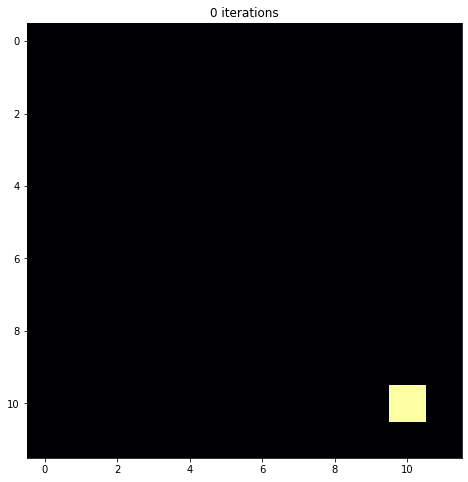

TabularQLearning Training: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.76it/s]


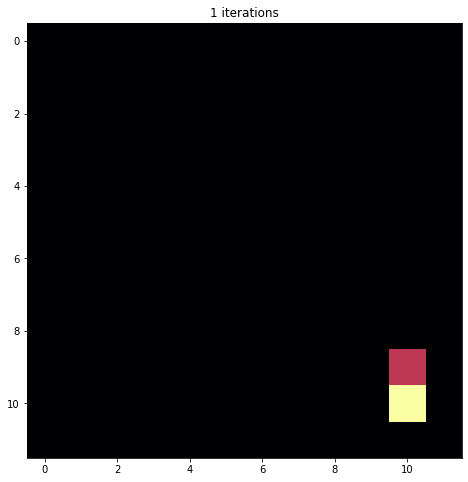

TabularQLearning Training: 100%|███████████████████████████████████████████████████████| 10/10 [00:00<00:00, 27.12it/s]


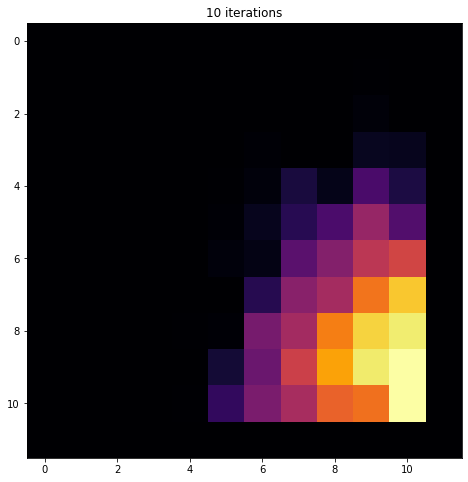

TabularQLearning Training: 100%|███████████████████████████████████████████████████| 1000/1000 [00:19<00:00, 50.88it/s]


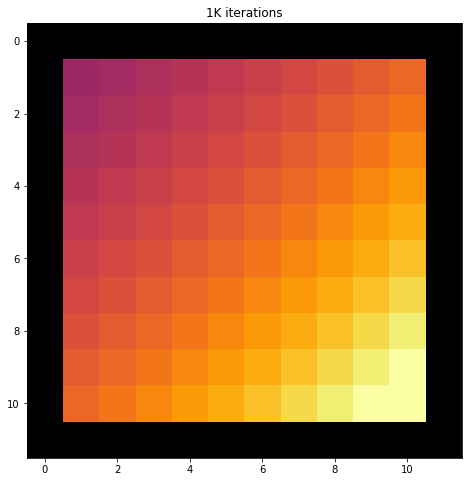

In [26]:
# Initialize our agent with the environment dimensions.
Qagent = AgentShelve.retrieve(
    agent='TabularQLearner', 
    keyword_arguments=dict(
        observation_shape = gridworld.observation_space.shape,
        n_actions = gridworld.action_space.n,
    )
)

f0 = plotQTable(gridworld, Qagent)
plt.title("0 iterations")
plt.show()

# Let agent discover terminal state 10 times.
Qagent.train(gridworld, 1, True)
gridworld.reset()

f1 = plotQTable(gridworld, Qagent)
plt.title("1 iterations")
plt.show()

# Let agent discover terminal state 10 times.
Qagent.train(gridworld, 10, True)
gridworld.reset()

f10 = plotQTable(gridworld, Qagent)
plt.title("10 iterations")
plt.show()

# Approximately uncover True value of MDP by running Q-learning for a sufficiently long time.
Qagent.train(gridworld, 1000, True)
gridworld.reset()

f_true = plotQTable(gridworld, Qagent)
plt.title("1K iterations")
plt.show()

## Conclusion

That's all folks!